## BitLinearLayer

In [2325]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Criando um código agnóstico de hardware

In [2326]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

Verificando se tem GPU

In [2327]:
print(f"Device: {device}")
if device == "cuda":
    !nvidia-smi

Device: cuda
Sun Oct 20 23:29:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX150           On  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8              N/A / ERR! |    158MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------------

Garantindo reprodutibilidade do experimento

In [2328]:
DEFAULT_SEED = 42

def set_seed(seed = DEFAULT_SEED):
    if seed:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

In [2329]:
set_seed()
x = torch.randn(1, 1, 4)
x, x.shape

(tensor([[[0.3367, 0.1288, 0.2345, 0.2303]]]), torch.Size([1, 1, 4]))

In [2330]:
from bitnet import BitLinear

set_seed()
bit_layer = BitLinear(4, 2)
y = bit_layer(x)
print(y)

tensor([[[ 0.1261, -0.1275]]], grad_fn=<UnsafeViewBackward0>)


In [2331]:
from torch.nn import Linear

set_seed()
linear_layer = Linear(4, 2)
y = linear_layer(x)
print(y)

tensor([[[ 0.7013, -0.3801]]], grad_fn=<ViewBackward0>)


In [2332]:
bit_layer.weight, linear_layer.weight

(Parameter containing:
 tensor([[ 0.3823,  0.4150, -0.1171,  0.4593],
         [-0.1096,  0.1009, -0.2434,  0.2936]], requires_grad=True),
 Parameter containing:
 tensor([[ 0.3823,  0.4150, -0.1171,  0.4593],
         [-0.1096,  0.1009, -0.2434,  0.2936]], requires_grad=True))

In [2333]:
bit_layer.bias, linear_layer.bias

(Parameter containing:
 tensor([ 0.4408, -0.3668], requires_grad=True),
 Parameter containing:
 tensor([ 0.4408, -0.3668], requires_grad=True))

### Dados Sintéticos

Definindo o número de samples e classes que serão gerados

In [2334]:
NUM_SAMPLES = 2000
NUM_CLASSES = 3

Implementações dos geradores de dados sintéticos por grau de complexidade

In [2335]:
from sklearn.datasets import make_blobs

class LinearlySeparableDataGenerator():
    def __init__(self):
        pass

    def generate(self,
        num_samples:int = NUM_SAMPLES, 
        num_classes:int = NUM_CLASSES,
        random_state: int = DEFAULT_SEED):  
        X, y = make_blobs(
                       n_samples = num_samples, 
                       n_features=2,
                       centers=num_classes,
                       cluster_std=2.0,
                       random_state=random_state, 
                       shuffle=True
                       )
        return X, y

# TODO tentar gerar 3 circulos (samples_per_class, 0), incrementar fator sempre,
class NonLinearlySeparableDataGenerator():
    import numpy as np

    def __init__(self):
        pass

 
    def generate(self, 
                 num_samples: int = NUM_SAMPLES, 
                 num_classes:int = NUM_CLASSES,
                 noise=0.05, 
                 factor:int=0.5, 
                 random_state: int = DEFAULT_SEED):
        
        np.random.seed(random_state)
        
        X = []
        y = []

        samples_per_class = num_samples // num_classes
        remainder = num_samples % num_classes

        # Distribute the remainder to one of the classes randomly or to the first if reproducible
        extra_samples = [1 if i < remainder else 0 for i in range(num_classes)]
        
        # Generate each class as a circle with increasing radius
        for i in range(num_classes):
            # Adjust the number of samples for this class considering the remainder
            adjusted_num_samples = samples_per_class + extra_samples[i]
            radius = factor * (i + 1)  # Incremental radius for each class
            theta = np.linspace(0, 2 * np.pi, adjusted_num_samples)
            x_circle = radius * np.cos(theta) + np.random.normal(scale=noise, size=adjusted_num_samples)
            y_circle = radius * np.sin(theta) + np.random.normal(scale=noise, size=adjusted_num_samples)
            
            X.append(np.vstack((x_circle, y_circle)).T)
            y += [i] * adjusted_num_samples  # Class labels
        
        X = np.vstack(X)
        y = np.array(y)
        
        return X, y

class MixedAndUnbalancedDataGenerator():
    def __init__(self):
        pass

    def generate(self,
                 num_samples = NUM_SAMPLES, 
                 num_classes = NUM_CLASSES,
                 random_state: int = DEFAULT_SEED):
        
        if random_state is not None:
            np.random.seed(random_state)
        
        # Generate unbalanced probabilities for each class
        class_weights = np.random.dirichlet(np.ones(num_classes) * 1.1)
        
        # Randomly distribute samples among classes to create a more unbalanced dataset
        samples_per_class = np.random.multinomial(num_samples, class_weights)
        
        # Sort class indices based on the number of samples per class (ascending)
        sorted_indices = np.argsort(samples_per_class)
        
        # Define standard deviations (noise levels) for each class
        min_std, max_std = 0.5, 1.5
        std_devs = np.linspace(min_std, max_std, num_classes)
        ordered_std_devs = np.zeros_like(std_devs)
        ordered_std_devs[sorted_indices] = std_devs

        # Determine centers for each class
        # Classes with more samples are further from the origin
        max_distance = 5  # Maximum distance from the origin for the largest class
        distances = np.linspace(0.5, max_distance, num_classes)  # Distances for each class
        distances = distances[::-1]  # Reverse to assign larger distances to classes with more samples

        # Generate random angles to place centers around a circle
        angles = np.random.uniform(0, 2 * np.pi, num_classes)
        centers = np.array([
            [distance * np.cos(angle), distance * np.sin(angle)]
            for distance, angle in zip(distances, angles)
        ])
        
        # Reorder centers so that classes with more samples have larger distances from the origin
        ordered_centers = np.zeros_like(centers)
        ordered_centers[sorted_indices] = centers

        # Generate blobs with specified centers and standard deviations
        X, y = make_blobs(
            n_samples=samples_per_class,
            centers=ordered_centers,
            cluster_std=ordered_std_devs,
            random_state=random_state
        )
        
        return X, y

Selecionando dados do experimento

In [2336]:
SYNTHETIC_DATA_GENERATOR = MixedAndUnbalancedDataGenerator()

X, y = SYNTHETIC_DATA_GENERATOR.generate()

In [2337]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y)

In [2338]:
print(f"Foram geradas um total de {len(X)} amostras!")
print("Exibindo o primeiro exemplo do dataset:")
print(f"features: [{X[0, 0]}, {X[0, 1]}]")
print(f"label: {y[0]}")

Foram geradas um total de 2000 amostras!
Exibindo o primeiro exemplo do dataset:
features: [1.5454849004745483, 0.3038060963153839]
label: 1


Exemplos por classe

In [2339]:
import pandas as pd

df = pd.DataFrame({"features": X[:, 0], "label": y})
df["label"].value_counts()

label
0    1011
1     553
2     436
Name: count, dtype: int64

Listagem de classes geradas

In [2340]:
np.unique(y)

array([0, 1, 2])

Visualizando os dados do dataset gerado

Text(0, 0.5, 'x2')

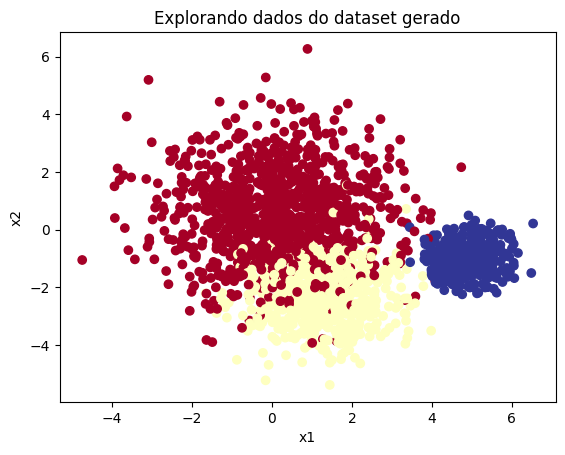

In [2341]:
import matplotlib.pyplot as plt

#plt.style.use('default')
#plt.rcParams.update({'font.size': 8})

plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c = y, 
            cmap=plt.cm.RdYlBu)
plt.title("Explorando dados do dataset gerado")
plt.xlabel("x1")
plt.ylabel("x2")

Divisão dos dados de treinamento e teste

In [2342]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=DEFAULT_SEED)

In [2343]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))
print(X_train.shape, y_train.shape)

1600 1600
400 400
torch.Size([1600, 2]) torch.Size([1600])


In [2344]:
print(X_train[0], y_train[0])
print(X_test[0], y_test[0])

tensor([0.8869, 0.0967]) tensor(0)
tensor([0.1381, 0.4499]) tensor(0)


### Datasets & Dataloaders

In [2345]:
from torch.utils.data import Dataset
from typing import Tuple

class CustomDataset(Dataset):
    def __init__(self, features: list, 
                        targets: list, 
                        transform = None, 
                        target_transform = None,
                        dtype = torch.float):
        super().__init__()
        self.features = features
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform
        self.dtype = dtype

    def __getitem__(self, idx):
        feature, target = self.features[idx], self.targets[idx]
        
        feature = torch.tensor(feature, 
                               dtype=self.dtype)
        
        target = torch.tensor(target)
        
        if self.transform:
            feature = self.transform(feature)
        if self.target_transform:
            target = self.target_transform(target)
        return feature, target
    
    def __len__(self):
        return len(self.targets)

Transformando dados de treinamento e teste em datasets

In [2346]:
train_dataset = CustomDataset(features = X_train, 
                              targets = y_train)

test_dataset = CustomDataset(features = X_test, 
                             targets = y_test)

print(len(train_dataset), len(test_dataset))
print(train_dataset[0][0], test_dataset[0][1])

1600 400
tensor([0.8869, 0.0967]) tensor(0)


Parâmetros para criação dos dataloaders, sendo o BATCH_SIZE um hiperparâmetro do treinamento

In [2347]:
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

Definindo dataloaders de treinamento e teste a partir dos datasets

In [2348]:
from torch.utils.data import DataLoader


train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              # reordena exemplos a cada época
                              shuffle = True,
                              num_workers = NUM_WORKERS)

test_dataloader = DataLoader(dataset = test_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = False, 
                              num_workers = NUM_WORKERS)

len(train_dataloader), len(test_dataloader)

(1600, 400)

In [2349]:
train_batch_features, train_batch_labels = next(iter(train_dataloader))

print(len(train_batch_features), len(train_batch_labels))
print(train_batch_features[0], train_batch_labels[0])

1 1
tensor([ 3.9076, -0.3102]) tensor(0)


### Arquitetura dos Modelos

Modelo base utilizando camadas nn.Linear

In [2350]:
import torch.nn as nn

class BaseModel(nn.Module):
    def __init__(self, input_size: int, hidden_units: int, output_size: int):
        super().__init__()
        self.name = "Base"
        self.linear_layer1 = nn.Linear(in_features=input_size, out_features=hidden_units)
        self.linear_layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.linear_layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.linear_layer4 = nn.Linear(in_features=hidden_units, out_features=output_size)
        self.activation = nn.Tanh()
    
    def forward(self, x):
        x = self.linear_layer1(x)
        x = self.activation(x)
        x = self.linear_layer2(x)
        x = self.activation(x)
        x = self.linear_layer3(x)
        x = self.activation(x)
        x = self.linear_layer4(x)
        return x


Modelo utilizando camadas binet.BitNetLinear

In [2351]:
import torch.nn as nn

class BitModel(nn.Module):
    def __init__(self, input_size:int, hidden_units:int, output_size:int):
        super().__init__()
        self.name = "Bitnet"
        self.bit_layer1 = BitLinear(in_features=input_size, out_features=hidden_units)
        self.bit_layer2 = BitLinear(in_features=hidden_units, out_features=hidden_units)
        self.bit_layer3 = BitLinear(in_features=hidden_units, out_features=hidden_units)
        self.bit_layer4 = BitLinear(in_features=hidden_units, out_features=output_size)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.bit_layer1(x)
        x = self.activation(x)
        x = self.bit_layer2(x)
        x = self.activation(x)
        x = self.bit_layer3(x)
        x = self.activation(x)
        x = self.bit_layer4(x)
        return x
    

In [2352]:
from torchinfo import summary

In [2353]:
INPUT_SIZE = 2
HIDDEN_UNITS = 5

In [2354]:
base_model = BaseModel(input_size=INPUT_SIZE, 
                     hidden_units=HIDDEN_UNITS, 
                     output_size=NUM_CLASSES
                     ).to(device)
summary(base_model, input_size=(1, 2, ))

Layer (type:depth-idx)                   Output Shape              Param #
BaseModel                                [1, 3]                    --
├─Linear: 1-1                            [1, 5]                    15
├─Tanh: 1-2                              [1, 5]                    --
├─Linear: 1-3                            [1, 5]                    30
├─Tanh: 1-4                              [1, 5]                    --
├─Linear: 1-5                            [1, 5]                    30
├─Tanh: 1-6                              [1, 5]                    --
├─Linear: 1-7                            [1, 3]                    18
Total params: 93
Trainable params: 93
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [2355]:
bit_model = BitModel(input_size=INPUT_SIZE, 
                     hidden_units=HIDDEN_UNITS, 
                     output_size=NUM_CLASSES
                     ).to(device)
summary(bit_model, input_size=(1, 2, ))

Layer (type:depth-idx)                   Output Shape              Param #
BitModel                                 [1, 3]                    --
├─BitLinear: 1-1                         [1, 5]                    15
├─Tanh: 1-2                              [1, 5]                    --
├─BitLinear: 1-3                         [1, 5]                    30
├─Tanh: 1-4                              [1, 5]                    --
├─BitLinear: 1-5                         [1, 5]                    30
├─Tanh: 1-6                              [1, 5]                    --
├─BitLinear: 1-7                         [1, 3]                    18
Total params: 93
Trainable params: 93
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### Treinamento dos Modelos

In [2356]:
from torchmetrics.classification import Accuracy

from engine import train

DEFAULT_ACCURACY = Accuracy(task="multiclass", 
                            num_classes=NUM_CLASSES)

Definição de parâmetros de treinamento

In [2357]:
EPOCHS = 10
LEARNING_RATE = 1e-3

Definindo da loss e otimizador para rede BitNet

In [2358]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=bit_model.parameters(), lr=LEARNING_RATE)

In [2359]:
bit_results = train(model = bit_model, 
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                num_epochs=EPOCHS,
                criteria=criteria,
                optimizer=optimizer,
                metrics=DEFAULT_ACCURACY,
                device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.0417, Train Acc: 0.54% | Test Loss: 0.9437, Test Acc: 0.75%
Epoch: 1 | Train Loss: 0.9423, Train Acc: 0.73% | Test Loss: 0.8636, Test Acc: 0.80%
Epoch: 2 | Train Loss: 0.8938, Train Acc: 0.69% | Test Loss: 0.8281, Test Acc: 0.71%
Epoch: 3 | Train Loss: 0.8758, Train Acc: 0.67% | Test Loss: 0.8030, Test Acc: 0.73%
Epoch: 4 | Train Loss: 0.8687, Train Acc: 0.66% | Test Loss: 0.8066, Test Acc: 0.70%
Epoch: 5 | Train Loss: 0.8631, Train Acc: 0.67% | Test Loss: 0.7809, Test Acc: 0.65%
Epoch: 6 | Train Loss: 0.8584, Train Acc: 0.68% | Test Loss: 0.7970, Test Acc: 0.79%
Epoch: 7 | Train Loss: 0.8611, Train Acc: 0.69% | Test Loss: 0.8090, Test Acc: 0.75%
Epoch: 8 | Train Loss: 0.8333, Train Acc: 0.73% | Test Loss: 0.7738, Test Acc: 0.80%
Epoch: 9 | Train Loss: 0.8334, Train Acc: 0.73% | Test Loss: 0.7701, Test Acc: 0.76%


Definindo loss e otimizador para a rede Baseline

In [2360]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=base_model.parameters(), lr=LEARNING_RATE)

In [2361]:
base_results = train(model = base_model, 
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                num_epochs=EPOCHS,
                criteria=criteria,
                optimizer=optimizer,
                metrics=DEFAULT_ACCURACY,
                device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.6174, Train Acc: 0.77% | Test Loss: 0.3241, Test Acc: 0.92%
Epoch: 1 | Train Loss: 0.2716, Train Acc: 0.91% | Test Loss: 0.1952, Test Acc: 0.94%
Epoch: 2 | Train Loss: 0.2329, Train Acc: 0.91% | Test Loss: 0.1778, Test Acc: 0.94%
Epoch: 3 | Train Loss: 0.2246, Train Acc: 0.91% | Test Loss: 0.1701, Test Acc: 0.94%
Epoch: 4 | Train Loss: 0.2158, Train Acc: 0.91% | Test Loss: 0.1769, Test Acc: 0.94%
Epoch: 5 | Train Loss: 0.2144, Train Acc: 0.92% | Test Loss: 0.1624, Test Acc: 0.94%
Epoch: 6 | Train Loss: 0.2135, Train Acc: 0.91% | Test Loss: 0.1654, Test Acc: 0.94%
Epoch: 7 | Train Loss: 0.2116, Train Acc: 0.91% | Test Loss: 0.1723, Test Acc: 0.93%
Epoch: 8 | Train Loss: 0.2115, Train Acc: 0.91% | Test Loss: 0.1630, Test Acc: 0.94%
Epoch: 9 | Train Loss: 0.2096, Train Acc: 0.92% | Test Loss: 0.1589, Test Acc: 0.94%


### Resultados do Experimento

In [2362]:
from utils import plot_results

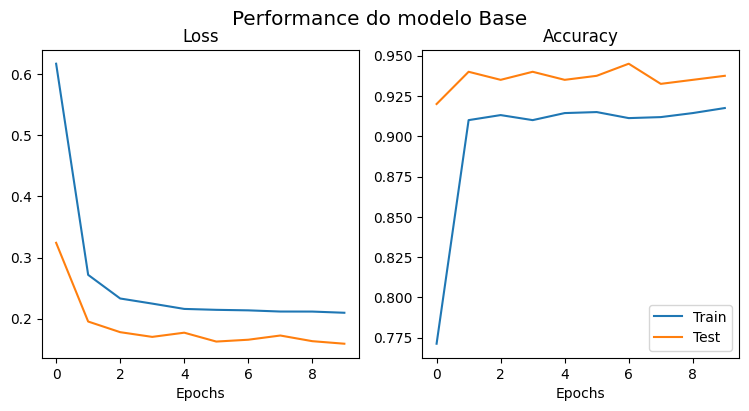

In [2363]:
# exibindo performance do modelo base
plot_results(results = base_results)

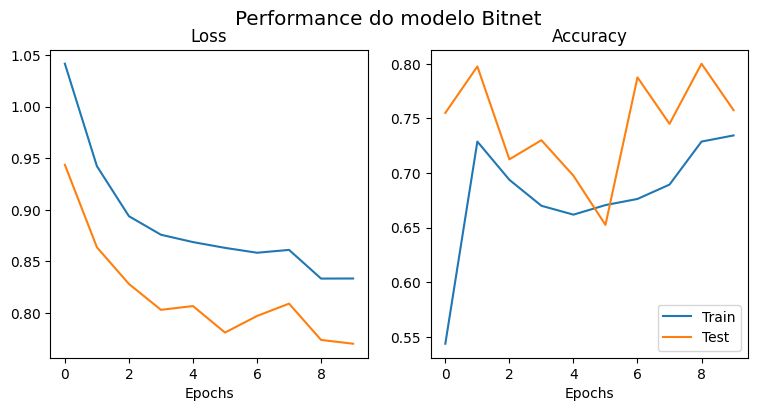

In [2364]:
# exibindo performance do modelo bitnet
plot_results(results = bit_results)

Baixando funções auxiliares para visualização das regiões de separação dos modelos

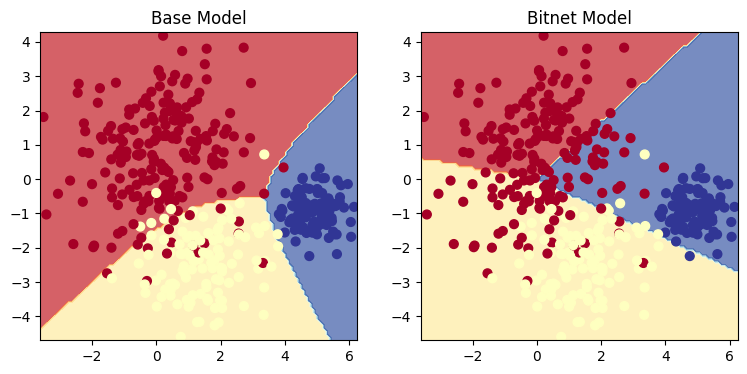

In [2365]:
from utils import plot_decision_boundary
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.title(f"{base_model.name} Model")
plot_decision_boundary(base_model, X_test, y_test)
plt.subplot(1, 2, 2)
plt.title(f"{bit_model.name} Model")
plot_decision_boundary(bit_model, X_test, y_test)